Nama: Abraham Naiborhu

Email: abraham.naiborhu@student.president.ac.id

Installing dependency and Importing Library 

In [1]:
#Buat Dataset
!pip install opendatasets 
import opendatasets as od

#Visualisasi data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Preprocessing data
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM

#Kita Train lah modelnya
import tensorflow as tf
from keras.callbacks import Callback


In [2]:
od.download('https://www.kaggle.com/ashfakyeafi/pbd-load-history')

Skipping, found downloaded files in "./pbd-load-history" (use force=True to force download)


In [3]:
df = pd.read_csv('/content/pbd-load-history/PDB_Load_History.csv')
print(df)
print(df.isnull().sum())
print("\n")
print(df.info())

              date  year  month  day  weekday  hour   demand  temperature
0         3/1/2003  2003      3    1        7     1  12863.0           29
1         3/1/2003  2003      3    1        7     2  12389.0           28
2         3/1/2003  2003      3    1        7     3  12155.0           29
3         3/1/2003  2003      3    1        7     4  12072.0           27
4         3/1/2003  2003      3    1        7     5  12160.0           29
...            ...   ...    ...  ...      ...   ...      ...          ...
103771  12/31/2014  2014     12   31        4    20  16955.0           22
103772  12/31/2014  2014     12   31        4    21  16243.0           21
103773  12/31/2014  2014     12   31        4    22  15525.0           21
103774  12/31/2014  2014     12   31        4    23  14759.0           18
103775  12/31/2014  2014     12   31        4    24  14071.0           19

[103776 rows x 8 columns]
date           0
year           0
month          0
day            0
weekday        0


In [4]:
a = []
for i in df.date.unique():
  a.append(df[df.date==i].mean())
df_new = pd.DataFrame(a)
df_new['date'] = df.date.unique()
df_new.set_index('date')

,year,month,day,weekday,hour,demand,temperature
date,,,,,,,
3/1/2003,2003.0,3.0,1.0,7.0,12.5,14216.875000,32.083333
3/2/2003,2003.0,3.0,2.0,1.0,12.5,13851.625000,34.458333
3/3/2003,2003.0,3.0,3.0,2.0,12.5,16348.875000,14.958333
3/4/2003,2003.0,3.0,4.0,3.0,12.5,16575.500000,18.791667
3/5/2003,2003.0,3.0,5.0,4.0,12.5,15391.875000,36.458333
...,...,...,...,...,...,...,...
12/27/2014,2014.0,12.0,27.0,7.0,12.5,12843.750000,40.416667
12/28/2014,2014.0,12.0,28.0,1.0,12.5,12779.208333,44.041667
12/29/2014,2014.0,12.0,29.0,2.0,12.5,14332.291667,34.125000


Text(0.5, 1.0, 'Temperature Average')

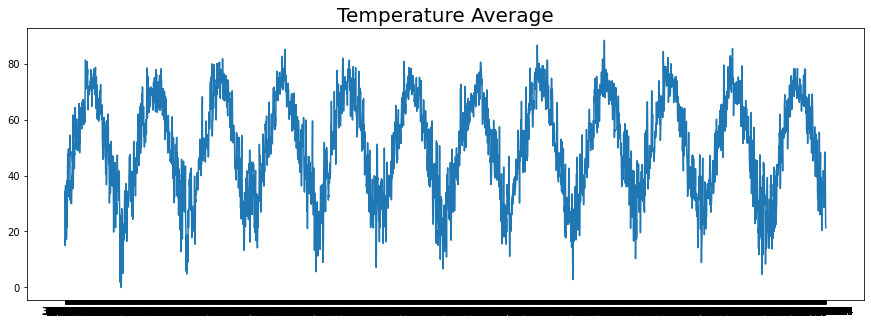

In [5]:
dates = df_new['date'].values
temp = df_new['temperature'].values

plt.figure(figsize=(15,5))
plt.plot(dates,temp)
plt.title('Temperature Average', fontsize = 20)

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
minMae = str((df_new['temperature'].max() - df_new['temperature'].min())*10/100)
print("Sesuai kriteria, MAE harus < 10%" + "\n")
print("Olehsebab itu, harus dibawah "+ minMae)

Sesuai kriteria, MAE harus < 10%

Olehsebab itu, harus dibawah 8.841666666666667


In [8]:
train_size = int(len(df_new['temperature'])*0.8)
df_temperature = df_new['temperature']
train_value = df_temperature[0:train_size]
test_value = df_temperature[train_size:]

print(len(df_new['temperature']))
print(train_size)
print(len(train_value))
print(len(test_value))
print(train_size/(len(df_new['temperature']))*100)
print(train_value.shape, test_value.shape)
print('\n')
print(train_value)
print('\n')
print(test_value)

4324
3459
3459
865
79.99537465309898
(3459,) (865,)


0       32.083333
1       34.458333
2       14.958333
3       18.791667
4       36.458333
          ...    
3454    73.333333
3455    72.583333
3456    73.083333
3457    74.208333
3458    68.500000
Name: temperature, Length: 3459, dtype: float64


3459    66.083333
3460    67.833333
3461    71.416667
3462    70.208333
3463    73.375000
          ...    
4319    40.416667
4320    44.041667
4321    34.125000
4322    23.500000
4323    21.291667
Name: temperature, Length: 865, dtype: float64


In [9]:
train_set = windowed_dataset(train_value, window_size=60, batch_size=100, shuffle_buffer=1000)
validation_set = windowed_dataset(test_value, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(optimizer = optimizer, metrics=['mae'], loss= tf.keras.losses.Huber())

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < 8.841666666666667 and logs.get('val_mae') < 8.841666666666667):
      print("\nMAE dan Val_MAE sudah dibawah 10%")
      self.model.stop_training = True
callbacks = myCallback()

history = model.fit(train_set,
              validation_data= validation_set,
              callbacks=[callbacks],
              epochs=100)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
34/34 [==============================] - 9s 145ms/step - loss: 50.3058 - mae: 50.8057 - val_loss: 47.7816 - val_mae: 48.2816
Epoch 2/100
34/34 [==============================] - 4s 125ms/step - loss: 49.6158 - mae: 50.1157 - val_loss: 47.1313 - val_mae: 47.6313
Epoch 3/100
34/34 [==============================] - 4s 120ms/step - loss: 48.9504 - mae: 49.4503 - val_loss: 46.3815 - val_mae: 46.8815
Epoch 4/100
34/34 [==============================] - 4s 121ms/step - loss: 48.0533 - mae: 48.5532 - val_loss: 45.2875 - val_mae: 45.7875
Epoch 5/100
34/34 [==============================] - 4s 122ms/step - loss: 46.6797 - mae: 47.1795 - val_loss: 43.5482 - val_mae: 44.0478
Epoch 6/100
34/34 [==============================] - 4s 123ms/step - loss: 44.4063 - mae: 44.9060 - val_loss: 40.5368 - val_mae: 41.0368
Epoch 7/100
34/34 [==============================] - 4s 123ms/step - loss: 40.1917 - mae: 40.6916 - val_loss: 34.6126 - val_mae: 35.1119
Epoch 8/100
34/34 [======================

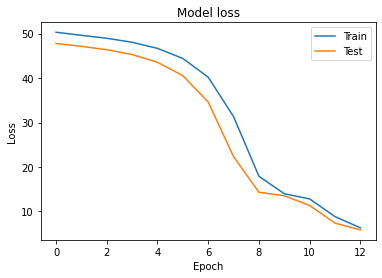

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='upper right')
plt.show()

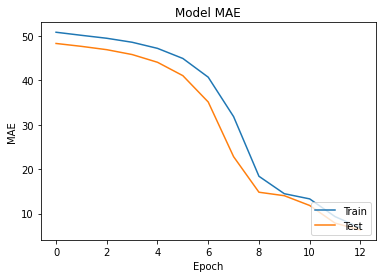

In [11]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='lower right')
plt.show()